In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-26 20:50:38.677047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load data
data_path = '/home/hpinkard_waller/data/lungdata'
background = 100
photons_per_pixel = 400
patch_size = 80
sample = 'full_volume_lung'

single_lens_data = np.load(os.path.join(data_path, 'full_volume_one_lens_measurements.npy'))
double_lens_data = np.load(os.path.join(data_path, 'full_volume_two_lens_measurements.npy'))
many_lens_data = np.load(os.path.join(data_path, 'full_volume_many_lens_measurements.npy'))

single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel

single_lens_data += background
double_lens_data += background
many_lens_data += background

data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min())
data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max())

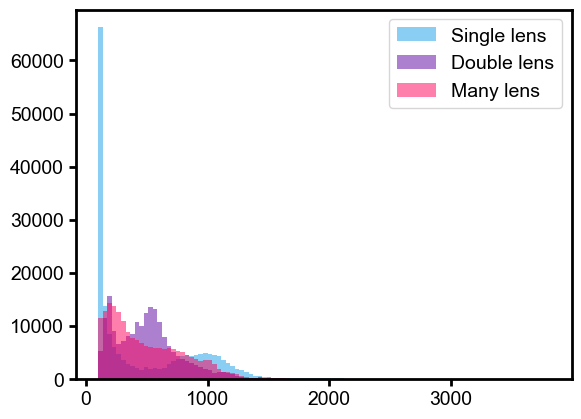

In [3]:
# plot histograms
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99.5), np.percentile(double_lens_data, 99.5), np.percentile(many_lens_data, 99.5))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:8].ravel(), bins=bins, label='Single lens', alpha=0.5)
_ = ax.hist(double_lens_data[:8].ravel(), bins=bins, label='Double lens', alpha=0.5)
_ = ax.hist(many_lens_data[:8].ravel(), bins=bins, label='Many lens', alpha=0.5)
ax.legend()

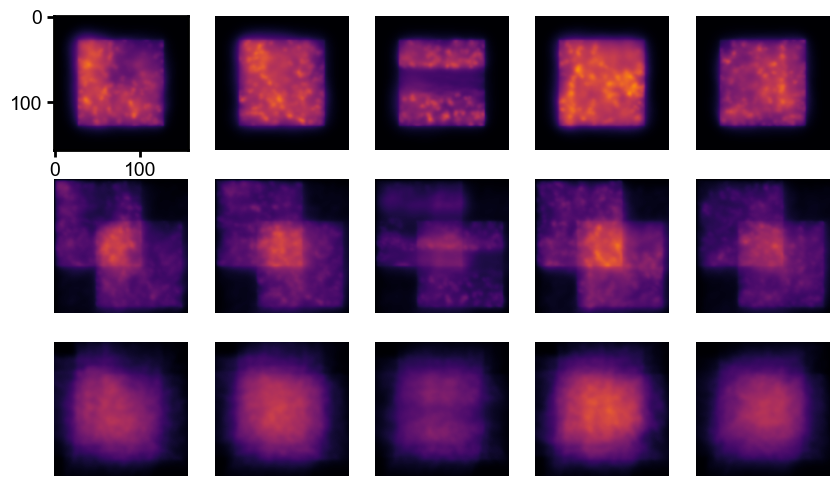

In [4]:
vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for i in range(5):
    axs[0, i].imshow(single_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[1, i].imshow(double_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(many_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    if i != 0:
        axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

In [36]:
# Try nearest neighbor distance
from encoding_information.information_estimation import *

patch_size=80

single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)


@partial(jit, static_argnums=1)
def nearest_neighbors_distance(X, k):
    """
    Compute the distance to the kth nearest neighbor for each point in X by
    exhaustively searching all points in X.
    
    X : ndarray, shape (n_samples, W, H) or (n_samples, num_features)
    k : int
    """
    X = X.reshape(X.shape[0], -1)
    distance_matrix = np.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=-1)
    kth_nn_index = np.argsort(distance_matrix, axis=-1)[:, k]
    kth_nn = X[kth_nn_index, :]
    kth_nn_dist = np.sum(np.abs(X - kth_nn), axis=-1)
    # kth_nn_dist = np.sqrt(np.sum((X - kth_nn)**2, axis=-1))
    return kth_nn_dist


k = 1000
print(nearest_neighbors_distance(single_lens_patches, k).mean(),
        nearest_neighbors_distance(double_lens_patches, k).mean(), 
        nearest_neighbors_distance(many_lens_patches, k).mean())


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:30<00:00, 161.54it/s]


2376169.8 1694338.4 1754372.9


# Generate and train

In [9]:
data_path = '/home/hpinkard_waller/data/lungdata'
background = 100
photons_per_pixel = 400
patch_size = 80
sample = 'full_volume_lung'




'/home/hpinkard_waller/data/lungdata/gaussian/full_volume_lung/single_lens/400 photons/100 background'

In [ ]:
for i in range(10):

    single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_noisy_patches = add_noise(single_lens_patches)
    double_lens_noisy_patches = add_noise(double_lens_patches)
    many_lens_noisy_patches = add_noise(many_lens_patches)


    single_lens_mi_pcnn = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, entropy_model='pixel_cnn', verbose=True)
    double_lens_mi_pcnn = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, entropy_model='pixel_cnn', verbose=True)
    many_lens_mi_pcnn = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, entropy_model='pixel_cnn', verbose=True)

    # do gaussian
    single_lens_mi_gaussian = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, verbose=True)
    double_lens_mi_gaussian = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches,  verbose=True)
    many_lens_mi_gaussian = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, verbose=True)


    def get_next_suffix(path):
        if not os.path.exists(path):
            return 0
        else:
            return len([f for f in os.listdir(path)])
        
    def save_data(data, gaussian_or_pcnn, lens):
        saving_path = [gaussian_or_pcnn, sample, lens, f'{photons_per_pixel}_photons', f'{background}_background']
        full_path = os.sep.join([data_path] + saving_path)
        # make this directory if it doesn't exist, creating intermediate directories as necessary
        os.makedirs(full_path, exist_ok=True)
        suffix = get_next_suffix(full_path)
        np.save(os.path.join(full_path, f'patch_{patch_size}_{suffix}.npy'), data)


    save_data(single_lens_mi_pcnn, 'pcnn', 'single_lens')
    save_data(double_lens_mi_pcnn, 'pcnn', 'double_lens')
    save_data(many_lens_mi_pcnn, 'pcnn', 'many_lens')

    save_data(single_lens_mi_gaussian, 'gaussian', 'single_lens')
    save_data(double_lens_mi_gaussian, 'gaussian', 'double_lens')
    save_data(many_lens_mi_gaussian, 'gaussian', 'many_lens')